# Baseline CNN

This is a baseline CNN, modified from (a Microsoft tutorial)[https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-train-model].

## Setup

First we import needed modules and (down)load our data.

In [3]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.optim import Adam
from torch.autograd import Variable
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from pathlib import Path
import gdown

In [4]:
# Load data
RESISC45_DIR = Path("..") / "NWPU-RESISC45"
if not RESISC45_DIR.exists():
    gdown.download(
        id="1nd0R9iljzkWd7Hhfyp2tH55KxAsKrzYj",
        output="NWPU-RESISC45.rar",
    )
    !unrar -inul x NWPU-RESISC45.rar

### Statistics

We now perform some quick statistics on the data $-$ specifically, finding the mean and standard deviation.

In [7]:
def get_mean_and_std():
    """Log the mean and standard deviation of the RESISC45 data."""
    # load in the data
    transformations = transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    )
    dataset = ImageFolder(root=RESISC45_DIR, transform=transformations)
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

    # Iterate through the dataset
    mean = 0.0
    std = 0.0
    total_samples = 0

    for images, _ in loader:
        batch_size = images.size(0)
        images = images.view(batch_size, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_samples += batch_size

    # Divide by number of samples and print results
    mean /= total_samples
    std /= total_samples

    print(f"Mean: {[round(i, 4) for i in mean.tolist()]}")
    print(f"Std: {[round(i, 4) for i in std.tolist()]}")


get_mean_and_std()

Mean: [0.368, 0.381, 0.3436]
Std: [0.1453, 0.1356, 0.132]


# Learning

We now will train our model.

## Setup and Hyperparameters

First, we define some basic hyperparameters, as shown below. We also find
which device we are training on. Then, we load and normalize the data, and
split it into train and test datasets. Finally, we define and create our neural network.

In [4]:
mean = (0.3680, 0.3810, 0.3436)
std = (0.1454, 0.1356, 0.1320)

train_ratio = 0.8
test_ratio = 0.2

batch_size = 128
learning_rate = 0.001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# Loading and normalizing the data.

transformations = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

dataset = ImageFolder(root=RESISC45_DIR, transform=transformations)
classes = dataset.class_to_idx

train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [6]:
# Define a convolution neural network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1
        )
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(
            in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1
        )
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(
            in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1
        )
        self.bn3 = nn.BatchNorm2d(24)
        self.conv4 = nn.Conv2d(
            in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1
        )
        self.bn4 = nn.BatchNorm2d(24)

        self.fc1 = nn.Linear(24 * 122 * 122, 45)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))
        output = F.relu(self.bn2(self.conv2(output)))
        output = self.pool(output)

        output = F.relu(self.bn3(self.conv3(output)))
        output = F.relu(self.bn4(self.conv4(output)))

        output = output.view(-1, 24 * 122 * 122)
        output = self.fc1(output)

        return output


# Instantiate a neural network model
model = Network()

### Training

We now enter the training phase of the notebook. First, we create our loss function and optimizer
(another hyperparameter). We chose the adam optimzier as it works well, with a small weight decay
to help with overfitting. We then define helper functions to train our model: one for saving the model,
two for testing train/test accuracy. Finally, we create our main training loop.

In [7]:
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

In [8]:
# Function to save the model
def saveModel():
    path = "./myFirstModel.pth"
    torch.save(model.state_dict(), path)


# Function to test the model with the test dataset and print the accuracy for the test images
def trainAccuracy():
    model.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in train_loader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = 100 * accuracy / total
    return accuracy


def testAccuracy():
    model.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = 100 * accuracy / total
    return accuracy


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    train_acc_list = []
    test_acc_list = []

    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        model.train()

        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()  # extract the loss value
            if i % 1000 == 999:
                # print every 1000 (twice per epoch)
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 1000))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy for this epoch when tested over all 10000 test images
        accuracy = trainAccuracy()
        train_acc_list.append(accuracy)
        print(
            "For epoch",
            epoch + 1,
            "the train accuracy over the whole test set is %d %%" % (accuracy),
        )
        accuracy = testAccuracy()
        test_acc_list.append(accuracy)
        print(
            "For epoch",
            epoch + 1,
            "the test accuracy over the whole test set is %d %%" % (accuracy),
        )

        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

    return train_acc_list, test_acc_list

Finally, we train our model, for ten epochs, and load the best model we have.
While training, we also saved our best accuracies.

In [10]:
# Let's build our model
train_acc_list, test_acc_list = train(10)
print("Finished Training")

# Test which classes performed well
testAccuracy()

# Let's load the model we just created and test the accuracy per label
model = Network()
path = "myFirstModel.pth"
model.load_state_dict(torch.load(path))

The model will be running on cuda:0 device
For epoch 1 the train accuracy over the whole test set is 17 %
For epoch 1 the test accuracy over the whole test set is 15 %
For epoch 2 the train accuracy over the whole test set is 31 %
For epoch 2 the test accuracy over the whole test set is 23 %
For epoch 3 the train accuracy over the whole test set is 49 %
For epoch 3 the test accuracy over the whole test set is 32 %
For epoch 4 the train accuracy over the whole test set is 57 %
For epoch 4 the test accuracy over the whole test set is 33 %
For epoch 5 the train accuracy over the whole test set is 69 %
For epoch 5 the test accuracy over the whole test set is 33 %
For epoch 6 the train accuracy over the whole test set is 78 %
For epoch 6 the test accuracy over the whole test set is 32 %
For epoch 7 the train accuracy over the whole test set is 89 %
For epoch 7 the test accuracy over the whole test set is 33 %
For epoch 8 the train accuracy over the whole test set is 93 %
For epoch 8 the tes

<All keys matched successfully>

### Visualization

We now plot our training and testing accuracies across the epochs.

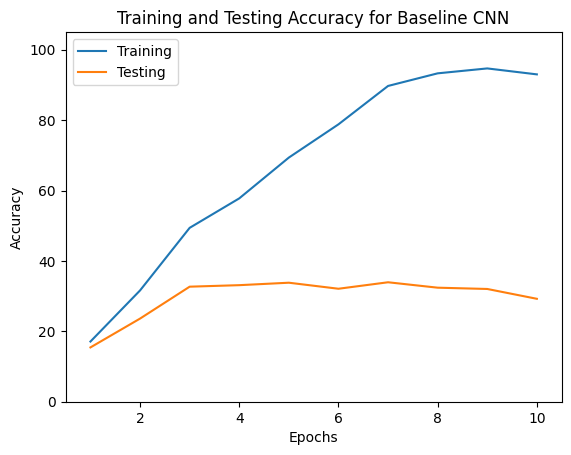

In [15]:
import matplotlib.pyplot as plt

epochs = [x + 1 for x in range(10)]

plt.plot(epochs, train_acc_list, label="Training")
plt.plot(epochs, test_acc_list, label="Testing")
plt.ylim(0, 105)
plt.xlim(0.5, 10.5)
plt.title("Training and Testing Accuracy for Baseline CNN")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Validation

Now that we've trained our model, we create some visualizations to help us validate the accuracy. 
Here, we are creating ag rid of images, and comparing the actual vs. predicted lables. This lets
us visualize what the model does right and what it does wrong.

In [9]:
import matplotlib.pyplot as plt
import numpy as np


# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader
    images, labels = next(iter(test_loader))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))

    # Show the real labels on the screen
    print(
        "Real labels: ",
        " ".join("%5s" % list(classes.keys())[labels[j]] for j in range(batch_size)),
    )

    # Let's see what if the model identifiers the  labels of those example
    outputs = model(images)

    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)

    # Let's show the predicted labels on the screen to compare with the real ones
    print(
        "Predicted: ",
        " ".join("%5s" % list(classes.keys())[predicted[j]] for j in range(batch_size)),
    )

In [12]:
model = Network()
path = "myFirstModel.pth"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

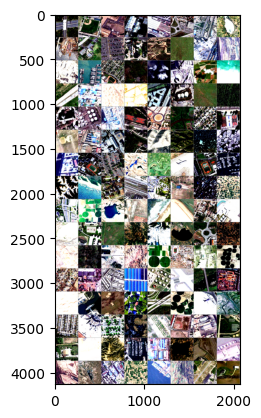

Real labels:  overpass baseball_diamond palace church railway_station roundabout overpass  lake  ship medium_residential parking_lot mobile_home_park terrace meadow airplane terrace industrial_area harbor ground_track_field forest cloud thermal_power_station cloud beach freeway industrial_area desert rectangular_farmland commercial_area storage_tank meadow forest church storage_tank industrial_area basketball_court roundabout wetland dense_residential basketball_court circular_farmland industrial_area railway_station basketball_court mountain mountain sea_ice sea_ice church ground_track_field parking_lot  lake river airplane ground_track_field harbor snowberg beach medium_residential railway palace sparse_residential dense_residential rectangular_farmland overpass circular_farmland  lake airport beach beach medium_residential airplane desert basketball_court meadow mountain snowberg  lake roundabout chaparral mountain forest airport mountain circular_farmland ground_track_field palace 

In [13]:
testBatch()